In [3]:
# Kernel: scseq-rdj

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from anndata import AnnData

import sys
sys.path.append('.')  # Add current directory to path
from thresholdpy import ThresholdPy, pp_threshold_proteins

np.random.seed(42)

# Functions

In [4]:
def create_realistic_citeseq_data(n_cells=2000, n_proteins=20):
    """
    Create realistic synthetic CITE-seq data with known structure.
    
    This function creates data that mimics real CITE-seq experiments:
    - Most proteins have a large noise population (low expression)
    - Some cells express each protein at high levels
    - Different proteins have different expression patterns
    """
    print(f"Creating synthetic CITE-seq data: {n_cells} cells x {n_proteins} proteins")
    
    # Initialize data matrix
    X = np.zeros((n_cells, n_proteins))
    
    # Protein names (realistic antibody panel)
    protein_names = [
        'CD3', 'CD4', 'CD8', 'CD19', 'CD14', 'CD16', 'CD56', 'CD45',
        'CD25', 'CD127', 'CD62L', 'CD44', 'CD95', 'CD45RO', 'CD45RA',
        'FOXP3', 'Ki67', 'PD1', 'CTLA4', 'LAG3'
    ][:n_proteins]
    
    # Create different protein expression patterns
    for i, protein in enumerate(protein_names):
        # Base noise level (all cells have some background)
        noise_level = np.random.uniform(0.5, 2.0)  # Varies by protein
        X[:, i] += np.random.exponential(noise_level, n_cells)
        
        # Determine fraction of expressing cells (varies by marker)
        if protein in ['CD3', 'CD45']:  # Broadly expressed
            expressing_fraction = 0.8
        elif protein in ['CD4', 'CD8', 'CD19', 'CD14']:  # Major lineages
            expressing_fraction = 0.3
        elif protein in ['CD25', 'FOXP3', 'Ki67']:  # Rare populations
            expressing_fraction = 0.05
        else:  # Moderate expression
            expressing_fraction = 0.15
        
        # Select expressing cells
        n_expressing = int(n_cells * expressing_fraction)
        expressing_cells = np.random.choice(n_cells, n_expressing, replace=False)
        
        # Add signal for expressing cells
        signal_strength = np.random.uniform(5, 15)  # Varies by protein
        X[expressing_cells, i] += np.random.exponential(signal_strength, n_expressing)
    
    # Add some technical noise
    X += np.random.normal(0, 0.1, X.shape)
    X = np.maximum(X, 0)  # Ensure non-negative
    
    # Create AnnData object
    adata = AnnData(X)
    adata.var_names = protein_names
    adata.obs_names = [f'Cell_{i:04d}' for i in range(n_cells)]
    
    # Add some cell metadata
    adata.obs['total_protein_counts'] = np.sum(X, axis=1)
    adata.obs['n_proteins_detected'] = np.sum(X > 1, axis=1)
    
    # Store raw data in layer
    adata.layers['protein_raw'] = X.copy()
    
    print(f"Data created successfully!")
    print(f"Mean counts per cell: {np.mean(adata.obs['total_protein_counts']):.1f}")
    print(f"Mean proteins detected per cell: {np.mean(adata.obs['n_proteins_detected']):.1f}")
    
    return adata

# Examples

## Demonstrate basic ThresholdPy usage

In [5]:
print("\n" + "="*50)
print("BASIC USAGE EXAMPLE")
print("="*50)

# Create synthetic data
adata = create_realistic_citeseq_data(n_cells=1000, n_proteins=10)

# Method 1: Using the scanpy-style preprocessing function
print("\n1. Using pp_threshold_proteins (scanpy-style):")
pp_threshold_proteins(adata, protein_layer='protein_raw', inplace=True)

# Access results
threshold_model = adata.uns['threshold_model']
summary = threshold_model.get_threshold_summary()
print(summary)

# Method 2: Using ThresholdPy class directly
print("\n2. Using ThresholdPy class directly:")
model = ThresholdPy(n_components=2, random_state=42)
model.fit_transform(adata, protein_layer='protein_raw', 
                    output_layer='protein_denoised_v2')

summary2 = model.get_threshold_summary()
print("Thresholds calculated:")
for _, row in summary2.iterrows():
    print(f"  {row['protein']}: {row['threshold']:.2f}")

display(adata, model)


INFO:thresholdpy:Starting ThresholdPy fitting...
INFO:thresholdpy:Using 10 of 10 proteins
INFO:thresholdpy:Fitting GMM for CD3 (1/10)



BASIC USAGE EXAMPLE
Creating synthetic CITE-seq data: 1000 cells x 10 proteins
Data created successfully!
Mean counts per cell: 44.0
Mean proteins detected per cell: 6.2

1. Using pp_threshold_proteins (scanpy-style):


INFO:thresholdpy:Fitting GMM for CD4 (2/10)
INFO:thresholdpy:Fitting GMM for CD8 (3/10)
INFO:thresholdpy:Fitting GMM for CD19 (4/10)
INFO:thresholdpy:Fitting GMM for CD14 (5/10)
INFO:thresholdpy:Fitting GMM for CD16 (6/10)
INFO:thresholdpy:Fitting GMM for CD56 (7/10)
INFO:thresholdpy:Fitting GMM for CD45 (8/10)
INFO:thresholdpy:Fitting GMM for CD25 (9/10)
INFO:thresholdpy:Fitting GMM for CD127 (10/10)
INFO:thresholdpy:Completed fitting for 10 proteins
INFO:thresholdpy:Starting ThresholdPy fitting...
INFO:thresholdpy:Using 10 of 10 proteins
INFO:thresholdpy:Fitting GMM for CD3 (1/10)
INFO:thresholdpy:Fitting GMM for CD4 (2/10)
INFO:thresholdpy:Fitting GMM for CD8 (3/10)
INFO:thresholdpy:Fitting GMM for CD19 (4/10)
INFO:thresholdpy:Fitting GMM for CD14 (5/10)
INFO:thresholdpy:Fitting GMM for CD16 (6/10)
INFO:thresholdpy:Fitting GMM for CD56 (7/10)
INFO:thresholdpy:Fitting GMM for CD45 (8/10)
INFO:thresholdpy:Fitting GMM for CD25 (9/10)
INFO:thresholdpy:Fitting GMM for CD127 (10/10)
INFO:

  protein  threshold  converged  n_valid_cells          aic          bic  \
0     CD3   7.143564       True            994  2634.108964  2658.617650   
1     CD4   2.541321       True            971  2110.508096  2134.899729   
2     CD8   3.349617       True            979  2136.853111  2161.285769   
3    CD19   5.824254       True            982  2532.644601  2557.092558   
4    CD14   2.806011       True            973  2275.814830  2300.216750   
5    CD16   1.988207       True            955  1398.382492  1422.691048   
6    CD56   3.400802       True            979  1874.414790  1898.847449   
7    CD45   7.758461       True            992  2401.339153  2425.837769   
8    CD25   2.773129       True            981  1662.761541  1687.204403   
9   CD127   3.588463       True            977  2061.846879  2086.269312   

   log_likelihood  
0       -1.319974  
1       -1.081621  
2       -1.086238  
3       -1.284442  
4       -1.164345  
5       -0.726902  
6       -0.952204  
7  

AnnData object with n_obs × n_vars = 1000 × 10
    obs: 'total_protein_counts', 'n_proteins_detected'
    uns: 'threshold_model'
    layers: 'protein_raw', 'protein_denoised', 'protein_denoised_v2'

## Demonstrate advanced ThresholdPy features

In [6]:
print("\n" + "="*50)
print("ADVANCED USAGE EXAMPLE")
print("="*50)

# Create larger dataset
adata_adv = create_realistic_citeseq_data(n_cells=2000, n_proteins=20)

# Advanced configuration
print("\n1. Using custom GMM parameters:")
model_adv = ThresholdPy(
    n_components=3,  # Try 3 components instead of 2
    max_iter=200,    # More iterations for better convergence
    covariance_type='diag',  # Diagonal covariance (faster)
    random_state=123
)

# Fit to specific proteins only
lineage_markers = ['CD3', 'CD4', 'CD8', 'CD19', 'CD14']
print(f"\n2. Analyzing subset of proteins: {lineage_markers}")

model_adv.fit(adata_adv, protein_layer='protein_raw', protein_names=lineage_markers)
model_adv.transform(adata_adv, protein_layer='protein_raw', 
                output_layer='lineage_denoised')

# Get detailed statistics
summary = model_adv.get_threshold_summary()
print("\nDetailed fitting statistics:")
print(summary[['protein', 'threshold', 'converged', 'aic', 'bic']])

display(adata_adv, model_adv)


INFO:thresholdpy:Starting ThresholdPy fitting...
INFO:thresholdpy:Using 5 of 20 proteins
INFO:thresholdpy:Fitting GMM for CD3 (1/5)
INFO:thresholdpy:Fitting GMM for CD4 (2/5)


INFO:thresholdpy:Fitting GMM for CD8 (3/5)
INFO:thresholdpy:Fitting GMM for CD19 (4/5)
INFO:thresholdpy:Fitting GMM for CD14 (5/5)
INFO:thresholdpy:Completed fitting for 5 proteins



ADVANCED USAGE EXAMPLE
Creating synthetic CITE-seq data: 2000 cells x 20 proteins
Data created successfully!
Mean counts per cell: 73.6
Mean proteins detected per cell: 11.5

1. Using custom GMM parameters:

2. Analyzing subset of proteins: ['CD3', 'CD4', 'CD8', 'CD19', 'CD14']

Detailed fitting statistics:
  protein  threshold  converged          aic          bic
0     CD3   3.748182       True  5287.279522  5332.034572
1     CD4   2.735237       True  4930.782363  4975.468674
2     CD8   2.071116       True  4508.667570  4553.300913
3    CD19   2.145622       True  4767.302955  4811.993325
4    CD14   1.421950       True  3971.729199  4016.247255


AnnData object with n_obs × n_vars = 2000 × 20
    obs: 'total_protein_counts', 'n_proteins_detected'
    layers: 'protein_raw', 'lineage_denoised'

## Demonstrate visualization capabilities


VISUALIZATION EXAMPLE


TypeError: FigureBase.subplots() got an unexpected keyword argument 'figsize'

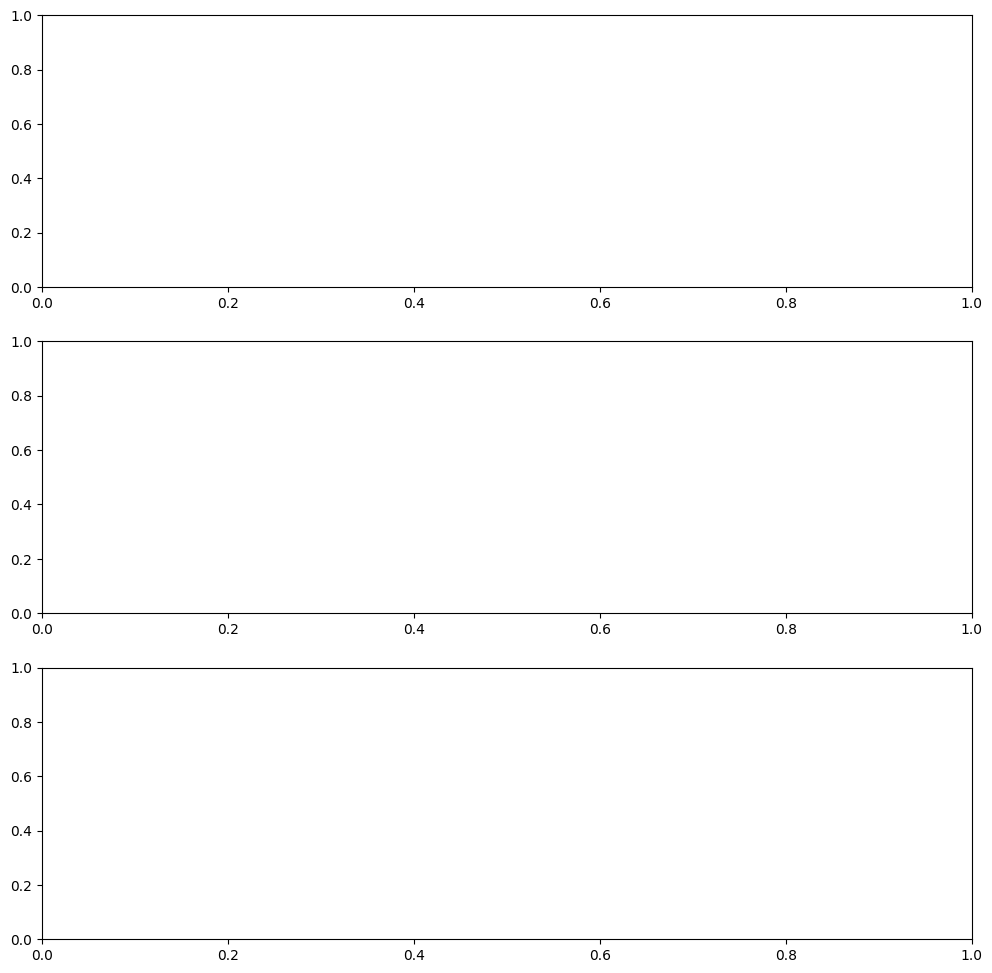

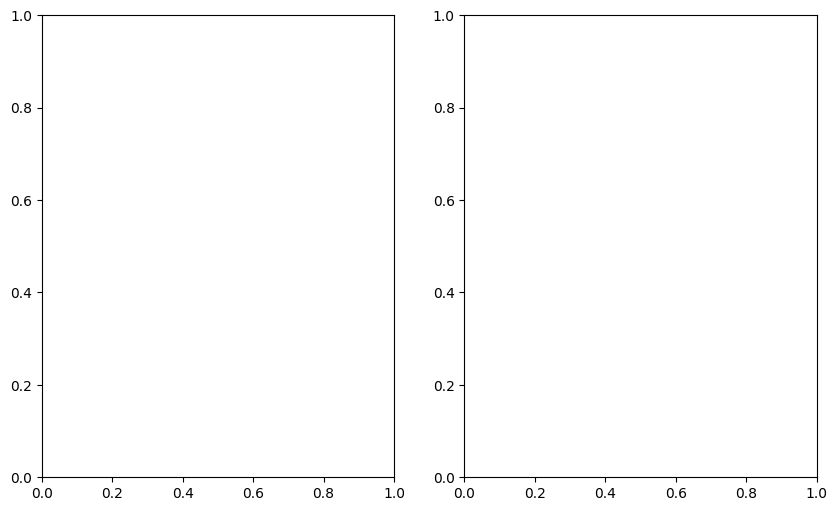

In [ ]:
print("\n" + "="*50)
print("VISUALIZATION EXAMPLE")
print("="*50)

# Plot distributions for a few proteins
proteins_to_plot = ['CD3', 'CD4', 'CD19']

for i, protein in enumerate(proteins_to_plot):
    if protein in model_adv.thresholds_:
        # Use ThresholdPy's built-in plotting
        protein_fig = model_adv.plot_protein_distribution(
            protein, adata_adv, protein_layer='protein_raw')
        
        print(f"Generated distribution plot for {protein}")
        plt.show()  # Show individual plots
    else:
        print(f"Protein {protein} not found in fitted models")

plt.show()

## Demonstrate quality control and comparison analysis

In [ ]:
print("\n" + "="*50)
print("QUALITY CONTROL EXAMPLE")
print("="*50)

# Get original and denoised data
original_data = adata.layers['protein_raw']
denoised_data = adata.layers['protein_denoised']

# Calculate basic statistics
print("\n1. Basic statistics comparison:")

# Sparsity analysis
original_sparsity = np.mean(original_data == 0) * 100
denoised_sparsity = np.mean(denoised_data == 0) * 100

print(f"Original data sparsity: {original_sparsity:.1f}%")
print(f"Denoised data sparsity: {denoised_sparsity:.1f}%")
print(f"Sparsity increase: {denoised_sparsity - original_sparsity:.1f} percentage points")

# Count statistics
original_total = np.sum(original_data)
denoised_total = np.sum(denoised_data)

print(f"\nTotal counts - Original: {original_total:.0f}")
print(f"Total counts - Denoised: {denoised_total:.0f}")
print(f"Counts retained: {denoised_total/original_total*100:.1f}%")

# Per-protein analysis
print("\n2. Per-protein analysis:")
protein_stats = []

for i, protein in enumerate(adata.var_names):
    orig_nonzero = np.sum(original_data[:, i] > 0)
    denoised_nonzero = np.sum(denoised_data[:, i] > 0)
    
    orig_mean = np.mean(original_data[:, i])
    denoised_mean = np.mean(denoised_data[:, i])
    
    protein_stats.append({
        'protein': protein,
        'orig_expressing_cells': orig_nonzero,
        'denoised_expressing_cells': denoised_nonzero,
        'cells_retained_pct': denoised_nonzero/orig_nonzero*100 if orig_nonzero > 0 else 0,
        'orig_mean': orig_mean,
        'denoised_mean': denoised_mean,
        'mean_retained_pct': denoised_mean/orig_mean*100 if orig_mean > 0 else 0
    })

stats_df = pd.DataFrame(protein_stats)
print(stats_df[['protein', 'cells_retained_pct', 'mean_retained_pct']].round(1))

# Visualization of QC metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Cells expressing each protein
axes[0, 0].scatter(stats_df['orig_expressing_cells'], 
                    stats_df['denoised_expressing_cells'], alpha=0.7)
axes[0, 0].plot([0, stats_df['orig_expressing_cells'].max()], 
                [0, stats_df['orig_expressing_cells'].max()], 'r--', alpha=0.5)
axes[0, 0].set_xlabel('Original expressing cells')
axes[0, 0].set_ylabel('Denoised expressing cells')
axes[0, 0].set_title('Expressing cells: Original vs Denoised')

# Plot 2: Mean expression
axes[0, 1].scatter(stats_df['orig_mean'], stats_df['denoised_mean'], alpha=0.7)
axes[0, 1].plot([0, stats_df['orig_mean'].max()], 
                [0, stats_df['orig_mean'].max()], 'r--', alpha=0.5)
axes[0, 1].set_xlabel('Original mean expression')
axes[0, 1].set_ylabel('Denoised mean expression')
axes[0, 1].set_title('Mean expression: Original vs Denoised')

# Plot 3: Retention percentages
axes[1, 0].hist(stats_df['cells_retained_pct'], bins=15, alpha=0.7)
axes[1, 0].set_xlabel('Cells retained (%)')
axes[1, 0].set_ylabel('Number of proteins')
axes[1, 0].set_title('Distribution of cell retention rates')

# Plot 4: Overall distribution comparison
sample_cells = np.random.choice(adata.n_obs, 1000, replace=False)
orig_sample = original_data[sample_cells, :].flatten()
denoised_sample = denoised_data[sample_cells, :].flatten()

axes[1, 1].hist(orig_sample, bins=50, alpha=0.5, label='Original', density=True)
axes[1, 1].hist(denoised_sample, bins=50, alpha=0.5, label='Denoised', density=True)
axes[1, 1].set_xlabel('Expression level')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Overall expression distribution')
axes[1, 1].legend()
axes[1, 1].set_xlim(0, 20)  # Focus on lower range

plt.tight_layout()
plt.show()

display(stats_df)


## Demonstrate processing multiple samples

In [ ]:
print("\n" + "="*50)
print("BATCH PROCESSING EXAMPLE")
print("="*50)

# Simulate multiple samples with slightly different characteristics
samples = {}
sample_names = ['Sample_A', 'Sample_B', 'Sample_C']

print("Creating multiple samples with different characteristics...")

for i, sample_name in enumerate(sample_names):
    # Vary parameters slightly between samples
    np.random.seed(42 + i)  # Different seed for each sample
    n_cells = np.random.randint(800, 1200)  # Variable sample size
    
    adata = create_realistic_citeseq_data(n_cells=n_cells, n_proteins=10)
    
    # Add some sample-specific variation
    # Simulate batch effects
    batch_effect = np.random.normal(0, 0.2, adata.n_vars)
    adata.X *= (1 + batch_effect)
    adata.layers['protein_raw'] = adata.X.copy()
    
    samples[sample_name] = adata
    print(f"  {sample_name}: {n_cells} cells")

# Process each sample
print("\nProcessing samples with ThresholdPy...")
threshold_models = {}

for sample_name, adata in samples.items():
    print(f"\nProcessing {sample_name}...")
    
    # Apply ThresholdPy
    model = ThresholdPy(random_state=42)  # Same random state for consistency
    model.fit_transform(adata, protein_layer='protein_raw')
    
    threshold_models[sample_name] = model
    
    # Print summary for this sample
    summary = model.get_threshold_summary()
    converged_count = summary['converged'].sum()
    print(f"  Successfully fitted {converged_count}/{len(summary)} proteins")

# Compare thresholds across samples
print("\n3. Comparing thresholds across samples:")

all_thresholds = []
for sample_name, model in threshold_models.items():
    summary = model.get_threshold_summary()
    summary['sample'] = sample_name
    all_thresholds.append(summary[['protein', 'threshold', 'sample']])

combined_thresholds = pd.concat(all_thresholds)

# Pivot table for easy comparison
threshold_comparison = combined_thresholds.pivot(
    index='protein', columns='sample', values='threshold'
)

print("Threshold comparison across samples:")
print(threshold_comparison.round(2))

# Calculate coefficient of variation for each protein
threshold_cv = threshold_comparison.std(axis=1) / threshold_comparison.mean(axis=1)
print(f"\nCoefficient of variation in thresholds:")
for protein, cv in threshold_cv.items():
    print(f"  {protein}: {cv:.3f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Heatmap of thresholds
sns.heatmap(threshold_comparison.T, annot=True, fmt='.2f', 
            cmap='viridis', ax=axes[0])
axes[0].set_title('Thresholds across samples')
axes[0].set_xlabel('Protein')
axes[0].set_ylabel('Sample')

# Box plot of threshold variation
melted_thresholds = combined_thresholds.dropna()
sns.boxplot(data=melted_thresholds, x='protein', y='threshold', ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_title('Threshold variation across samples')

plt.tight_layout()
plt.show()

display(samples, threshold_models, combined_thresholds)


## Demonstrate integration with standard scanpy workflow

In [10]:

print("\n" + "="*50)
print("SCANPY INTEGRATION EXAMPLE")
print("="*50)

# Create data that simulates RNA + protein
print("Creating combined RNA + Protein dataset...")

# Create protein data
adata_protein = create_realistic_citeseq_data(n_cells=1500, n_proteins=15)

# Create mock RNA data (much larger feature space)
n_genes = 2000
rna_data = np.random.negative_binomial(2, 0.1, (adata_protein.n_obs, n_genes))

# Add some structure to RNA data
for i in range(n_genes):
    # Some genes are highly expressed in subsets of cells
    if i % 100 == 0:  # Every 100th gene
        expressing_cells = np.random.choice(
            adata_protein.n_obs, adata_protein.n_obs//5, replace=False
        )
        rna_data[expressing_cells, i] += np.random.negative_binomial(10, 0.3, len(expressing_cells))

# Create RNA AnnData
adata_rna = AnnData(rna_data.astype(float))
adata_rna.var_names = [f'Gene_{i:04d}' for i in range(n_genes)]
adata_rna.obs_names = adata_protein.obs_names.copy()

print(f"RNA data: {adata_rna.shape}")
print(f"Protein data: {adata_protein.shape}")

# Standard scanpy preprocessing for RNA
print("\n1. Processing RNA data with standard scanpy workflow:")

# Basic filtering
sc.pp.filter_cells(adata_rna, min_genes=200)
sc.pp.filter_genes(adata_rna, min_cells=3)

# Calculate QC metrics
adata_rna.var['mt'] = adata_rna.var_names.str.startswith('Gene_00')  # Mock MT genes
sc.pp.calculate_qc_metrics(adata_rna, percent_top=None, log1p=False, inplace=True)

# Normalization and log transformation
sc.pp.normalize_total(adata_rna, target_sum=1e4)
sc.pp.log1p(adata_rna)

# Feature selection
sc.pp.highly_variable_genes(adata_rna, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_rna.raw = adata_rna
adata_rna = adata_rna[:, adata_rna.var.highly_variable]

print(f"After filtering: {adata_rna.shape}")

# Process protein data with ThresholdPy
print("\n2. Processing protein data with ThresholdPy:")

pp_threshold_proteins(
    adata_protein, 
    protein_layer='protein_raw',
    output_layer='protein_denoised',
    inplace=True
)

# Get threshold model
threshold_model = adata_protein.uns['threshold_model']
summary = threshold_model.get_threshold_summary()
successful_proteins = summary[summary['converged']].shape[0]
print(f"Successfully processed {successful_proteins}/{len(summary)} proteins")

# Create combined analysis
print("\n3. Combining RNA and protein data for joint analysis:")

# Match cells (in case filtering removed some)
common_cells = adata_rna.obs_names.intersection(adata_protein.obs_names)
adata_rna_matched = adata_rna[common_cells, :].copy()
adata_protein_matched = adata_protein[common_cells, :].copy()

print(f"Common cells: {len(common_cells)}")

# Option 1: Store protein data in RNA object
adata_combined = adata_rna_matched.copy()
adata_combined.obsm['protein_raw'] = adata_protein_matched.layers['protein_raw']
adata_combined.obsm['protein_denoised'] = adata_protein_matched.layers['protein_denoised']

# Add protein names to uns
adata_combined.uns['protein_names'] = adata_protein_matched.var_names.tolist()

print("Combined data structure:")
print(f"  RNA genes: {adata_combined.n_vars}")
print(f"  Protein matrices in .obsm: {list(adata_combined.obsm.keys())}")
print(f"  Proteins: {len(adata_combined.uns['protein_names'])}")

# Proceed with standard scanpy analysis on RNA
print("\n4. Continuing with standard scanpy analysis:")

# PCA on RNA
sc.tl.pca(adata_combined, svd_solver='arpack')

# Neighbors and UMAP
sc.pp.neighbors(adata_combined, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_combined)

# Clustering
sc.tl.leiden(adata_combined, resolution=0.3)

print(f"Identified {len(adata_combined.obs['leiden'].unique())} clusters")

# Analyze protein expression by cluster
print("\n5. Analyzing protein expression by cluster:")

protein_denoised = adata_combined.obsm['protein_denoised']
clusters = adata_combined.obs['leiden']

cluster_protein_means = []
for cluster in clusters.unique():
    cluster_mask = clusters == cluster
    cluster_mean = np.mean(protein_denoised[cluster_mask, :], axis=0)
    cluster_protein_means.append(cluster_mean)

cluster_protein_df = pd.DataFrame(
    cluster_protein_means,
    index=[f'Cluster_{c}' for c in clusters.unique()],
    columns=adata_combined.uns['protein_names']
)

print("Mean protein expression by cluster:")
print(cluster_protein_df.round(2))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# UMAP colored by clusters
scatter = axes[0].scatter(
    adata_combined.obsm['X_umap'][:, 0], 
    adata_combined.obsm['X_umap'][:, 1],
    c=clusters.astype('category').cat.codes, 
    cmap='tab10', s=1, alpha=0.7
)
axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')
axes[0].set_title('Clusters (RNA-based)')

# Protein expression heatmap
sns.heatmap(cluster_protein_df.T, annot=True, fmt='.1f', 
            cmap='viridis', ax=axes[1], cbar_kws={'label': 'Mean expression'})
axes[1].set_title('Protein expression by cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Protein')

plt.tight_layout()
plt.show()

display(adata_combined, threshold_model)



SCANPY INTEGRATION EXAMPLE
Creating combined RNA + Protein dataset...
Creating synthetic CITE-seq data: 1500 cells x 15 proteins
Data created successfully!
Mean counts per cell: 52.4
Mean proteins detected per cell: 8.1


INFO:thresholdpy.thresholdpy:Starting ThresholdPy fitting...
INFO:thresholdpy.thresholdpy:Using 15 of 15 proteins
INFO:thresholdpy.thresholdpy:Fitting GMM for CD3 (1/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD4 (2/15)


RNA data: (1500, 2000)
Protein data: (1500, 15)

1. Processing RNA data with standard scanpy workflow:
After filtering: (1500, 619)

2. Processing protein data with ThresholdPy:


INFO:thresholdpy.thresholdpy:Fitting GMM for CD8 (3/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD19 (4/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD14 (5/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD16 (6/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD56 (7/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD45 (8/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD25 (9/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD127 (10/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD62L (11/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD44 (12/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD95 (13/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD45RO (14/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD45RA (15/15)
INFO:thresholdpy.thresholdpy:Completed fitting for 15 proteins


Successfully processed 15/15 proteins

3. Combining RNA and protein data for joint analysis:
Common cells: 1500
Combined data structure:
  RNA genes: 619
  Protein matrices in .obsm: ['protein_raw', 'protein_denoised']
  Proteins: 15

4. Continuing with standard scanpy analysis:


c:\Anaconda3\envs\scseq-rdj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 